# Introduction

Effect handlers, i.e., poutine in Pyro paralance, enables us to manipulate and perform computation on a Pyro model such as conditioning, generating a log_joint_prob() for a given model(). This ability ultimately leads to the implementation of different inference methods such as variational inference or variable elimination.

We will try to understand the mini pyro

In [1]:
import torch
import pyro.distributions as dist

In [2]:
import minipyro as pyro
from  minipyro import SVI, Adam, elbo

In [3]:
# Define a basic model with a single Normal latent random variable `loc`
# and a batch of Normally distributed observations.
def model(data):
    loc = pyro.sample("loc", dist.Normal(0., 1.))
    with pyro.plate("data", len(data), dim=-1):
        pyro.sample("obs", dist.Normal(loc, 1.), obs=data)

In [20]:
pyro.trace(model).get_trace(data)

OrderedDict([('loc',
              {'type': 'sample',
               'name': 'loc',
               'fn': Normal(loc: 0.0, scale: 1.0),
               'args': (),
               'value': tensor(-1.7952)}),
             ('obs',
              {'type': 'sample',
               'name': 'obs',
               'fn': Normal(loc: torch.Size([100]), scale: torch.Size([100])),
               'args': (),
               'value': tensor([1.8742, 1.8476, 2.7494, 2.5661, 3.8487, 3.6920, 2.6840, 0.8848, 3.3223,
                       1.7367, 3.3500, 3.3081, 3.1198, 4.2377, 4.1168, 2.7527, 1.6473, 1.3041,
                       3.5667, 3.7935, 3.5988, 1.4449, 2.6586, 4.8530, 3.7502, 2.4145, 2.8266,
                       3.1835, 4.3894, 4.5863, 3.9463, 2.1563, 2.3864, 3.0316, 2.5073, 3.2484,
                       3.4397, 3.1124, 3.6408, 3.4412, 2.8977, 3.7924, 2.7103, 3.0525, 3.5229,
                       5.3022, 1.5311, 1.4133, 2.3269, 3.8728, 4.0554, 3.1778, 2.7697, 2.6082,
                       3.5

In [21]:
pyro.trace(guide).get_trace(data)

OrderedDict([('guide_loc',
              {'type': 'param',
               'name': 'guide_loc',
               'fn': <function minipyro.param.<locals>.fn(init_value)>,
               'args': (tensor(0.),),
               'value': tensor(3.0121, requires_grad=True)}),
             ('guide_scale_log',
              {'type': 'param',
               'name': 'guide_scale_log',
               'fn': <function minipyro.param.<locals>.fn(init_value)>,
               'args': (tensor(0.),),
               'value': tensor(-1.3553, requires_grad=True)}),
             ('loc',
              {'type': 'sample',
               'name': 'loc',
               'fn': Normal(loc: 3.012122392654419, scale: 0.25786036252975464),
               'args': (),
               'value': tensor(3.0520, grad_fn=<AddBackward0>)})])

In [22]:
def model2():
    loc = pyro.param('loc2', torch.tensor(0.))
    pyro.sample('ob2', dist.Normal(loc, 1.))

In [23]:
pyro.trace(model2).get_trace()

OrderedDict([('loc2',
              {'type': 'param',
               'name': 'loc2',
               'fn': <function minipyro.param.<locals>.fn(init_value)>,
               'args': (tensor(0., requires_grad=True),),
               'value': tensor(0., requires_grad=True)}),
             ('ob2',
              {'type': 'sample',
               'name': 'ob2',
               'fn': Normal(loc: 0.0, scale: 1.0),
               'args': (),
               'value': tensor(0.3563, grad_fn=<AddBackward0>)})])

In [4]:
# Define a guide (i.e. variational distribution) with a Normal
    # distribution over the latent random variable `loc`.
def guide(data):
    guide_loc = pyro.param("guide_loc", torch.tensor(0.))
    guide_scale = pyro.param("guide_scale_log", torch.tensor(0.)).exp()
    pyro.sample("loc", dist.Normal(guide_loc, guide_scale))

In [5]:
# Generate some data.
torch.manual_seed(0)
data = torch.randn(100) + 3.0
pyro.get_param_store().clear()

In [6]:
import seaborn as sns

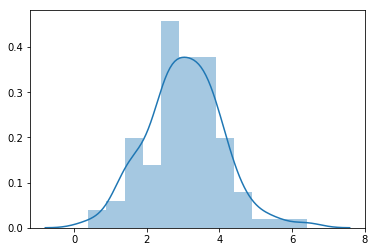

In [7]:
sns.distplot(data)

In [8]:
# Construct an SVI object so we can do variational inference on our model/guide pair.
svi = SVI(model, guide, Adam({"lr": 0.01}), elbo)

In [9]:
# Basic training loop
losses = []
for step in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    if step % 100 == 0:
        print("step {} loss = {}".format(step, loss))

step 0 loss = 291.2471618652344
step 100 loss = 212.1007537841797
step 200 loss = 184.7483673095703
step 300 loss = 166.82797241210938
step 400 loss = 235.90830993652344
step 500 loss = 173.93594360351562
step 600 loss = 178.1129150390625
step 700 loss = 150.7626190185547
step 800 loss = 151.26597595214844
step 900 loss = 150.60311889648438


In [10]:
import matplotlib.pyplot as plt

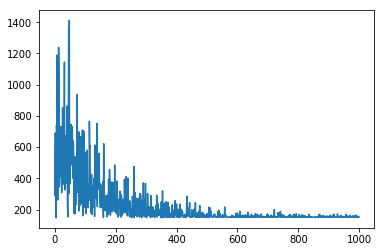

In [11]:
plt.plot(losses)

In [12]:
# Report the final values of the variational parameters
# in the guide after training.
for name, value in pyro.get_param_store().items():
    print("{} = {}".format(name, value.detach().cpu().numpy()))

# For this simple (conjugate) model we know the exact posterior. In
# particular we know that the variational distribution should be
# centered near 3.0. So let's check this explicitly.
assert (pyro.param("guide_loc") - 3.0).abs() < 0.1

guide_loc = 3.012122392654419
guide_scale_log = -1.3553370237350464


In [13]:
pyro.get_param_store()['guide_loc']

tensor(3.0121, requires_grad=True)

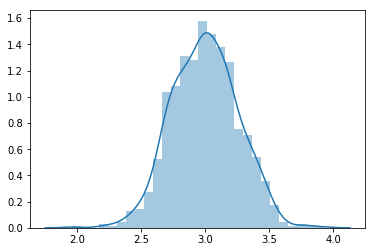

In [14]:
sns.distplot(torch.distributions.Normal(loc=pyro.get_param_store()['guide_loc'], scale=torch.exp(pyro.get_param_store()['guide_scale_log'])).sample((1000,)))

# Appendix

### Python context manager

In [15]:
class MyContext(object):

    def __init__(self, greeting):
        self.greeting = greeting

    def __enter__(self):
        return self.greeting

    def __exit__(self, *args):
        print('adios')

In [16]:
with MyContext('hello world') as greeting:
    print(greeting)

hello world
adios
